In [1]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [2]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

In [3]:
# setup helper for generating experiments (basically all sets of params to run through sim)
def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))


experiments = {
    "electorate_size": [10_000, 25_000], # not O(n^2) with KDTree, but still bad
    "clusters": [1, 2, 10, 25],
    "cluster_std": [1, 2, 3],
    "electoral_system": ["majority", "plurality", "approval"],
    "apathy_prob": [0, 0.01, 0.05],
    "candidates": np.arange(2, 10 + 1),
    "issues": np.arange(2, 25, 10, dtype=int),
    "n_approvals_per_voter": [2, 3, 5]
}

records = []
columns = [*experiments.keys(), "unweighted_fairness", "weighted_fairness"]
experiment_matrix = list(generate_experiment_matrix(experiments))

for params in tqdm(experiment_matrix):
    
    # setup objects
    voters = electorate.setup_electorate(**params)
    parties = candidates.setup_candidates(**params, electorate=voters)
    system = voting_system.setup_voting_system(name=params["electoral_system"], **params)
    
    # simulate elections
    sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())
    
    try:    
        result = sim.run()
        result_record = { 
            "unweighted_fairness": round(result.unweighted_fairness, 3),
            "weighted_fairness": round(result.weighted_fairness, 3),
            **params,
        }
        records.append(result_record)
    except AssertionError as e:
        # parameter matrix generates configurations that are potentially not supported by all
        # voting systems; in that case we just forgo running that param set in particular.
        if e is AssertionError("more votes than candidates"):
            continue

100%|███████████████████| 17496/17496 [1:09:10<00:00,  4.22it/s]


In [4]:
results_df = pd.DataFrame.from_records(records)
results_df

,unweighted_fairness,weighted_fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,n_approvals_per_voter
0,5.281,5.275,10000,1,1,majority,0.00,2,2,2
1,7.873,7.858,10000,1,1,majority,0.00,2,2,3
2,5.544,5.533,10000,1,1,majority,0.00,2,2,5
3,5.856,5.856,10000,1,1,majority,0.00,2,12,2
4,5.479,5.479,10000,1,1,majority,0.00,2,12,3
...,...,...,...,...,...,...,...,...,...,...
16627,0.893,0.834,25000,25,3,approval,0.05,10,12,3
16628,0.906,0.824,25000,25,3,approval,0.05,10,12,5
16629,0.910,0.859,25000,25,3,approval,0.05,10,22,2
16630,0.932,0.864,25000,25,3,approval,0.05,10,22,3


##### Store data or read from already performed experiment files

In [5]:
filepath = "data/plurality-vs-majority-vs-ranked-85076d6b-885d-4175-ba0f-38285fddfe54.csv"

In [6]:
# cache data so we don't need to start from scratch
assert not os.path.isfile(filepath), "data export already exists. Use a new uuid to prevent overwriting"
results_df.to_csv(filepath, index=False)
results_df = pd.read_csv(filepath)

In [7]:
# read from cache 
results_df = pd.read_csv(filepath)

# Investigation of fairness between majority and pluralism

In [8]:
# generate correlation matrices for both different systems
majority = results_df.electoral_system == "majority"
plurality = results_df.electoral_system == "plurality"
approval = results_df.electoral_system == "approval"

In [9]:
majority_subset = results_df[majority].drop(["electoral_system"], axis=1) 
plurality_subset = results_df[plurality].drop(["electoral_system"], axis=1)
approval_subset = results_df[approval].drop(["electoral_system"], axis=1)

In [10]:
approval_subset

,unweighted_fairness,weighted_fairness,electorate_size,clusters,cluster_std,apathy_prob,candidates,issues,n_approvals_per_voter
486,6.271,6.292,10000,1,1,0.00,2,2,2
487,5.153,5.160,10000,1,1,0.00,2,12,2
488,6.481,6.481,10000,1,1,0.00,2,22,2
489,3.885,3.857,10000,1,1,0.00,3,2,2
490,4.986,4.979,10000,1,1,0.00,3,2,3
...,...,...,...,...,...,...,...,...,...
16627,0.893,0.834,25000,25,3,0.05,10,12,3
16628,0.906,0.824,25000,25,3,0.05,10,12,5
16629,0.910,0.859,25000,25,3,0.05,10,22,2
16630,0.932,0.864,25000,25,3,0.05,10,22,3


In [15]:
# vector of correlation with fairness for both systems
majority_corr_record = dict(**majority_subset.corrwith(majority_subset.unweighted_fairness), **{"electoral_system": "majority"})
plurality_corr_record = dict(**plurality_subset.corrwith(plurality_subset.unweighted_fairness), **{"electoral_system": "plurality"})
approval_corr_record = dict(**approval_subset.corrwith(approval_subset.unweighted_fairness), **{"electoral_system": "approval"})

In [16]:
approval_corr_record

{'unweighted_fairness': 1.0,
 'weighted_fairness': 0.9898054326031532,
 'electorate_size': 0.0009710517763265868,
 'clusters': -0.43408858423145946,
 'cluster_std': -0.25484949842163646,
 'apathy_prob': 0.0018559099201799782,
 'candidates': -0.004866134092553478,
 'issues': 0.0027453925397144495,
 'n_approvals_per_voter': -0.00031368492073860325,
 'electoral_system': 'approval'}

In [17]:
# compose to make plotting easier
corr_df = pd.DataFrame.from_records(
    [majority_corr_record, plurality_corr_record, approval_corr_record]
).drop(["clusters", "weighted_fairness", "unweighted_fairness"], axis=1)

In [18]:
corr_df

,electorate_size,cluster_std,apathy_prob,candidates,issues,n_approvals_per_voter,electoral_system
0,-0.005111,-0.259135,-0.000933,-0.026488,0.051017,0.005203,majority
1,-0.005130,-0.258553,-0.005385,-0.005526,0.015837,0.002170,plurality
2,0.000971,-0.254849,0.001856,-0.004866,0.002745,-0.000314,approval


In [19]:
# convert to long to enable bar plot
long_corr_cols = ["measure", "value", "electoral_system"]
long_corr_df = pd.DataFrame(columns=long_corr_cols)

for system in ["majority", "plurality", "approval"]:
    for measure in corr_df.columns:
        for value in corr_df[ corr_df.electoral_system == system ][measure]:
            row = pd.DataFrame.from_records([{ "measure": measure, "value": value, "electoral_system": system }])
            long_corr_df = pd.concat([long_corr_df, row])
        
long_corr_df = long_corr_df.reset_index().drop("index", axis=1).drop([4, 9], axis=0)

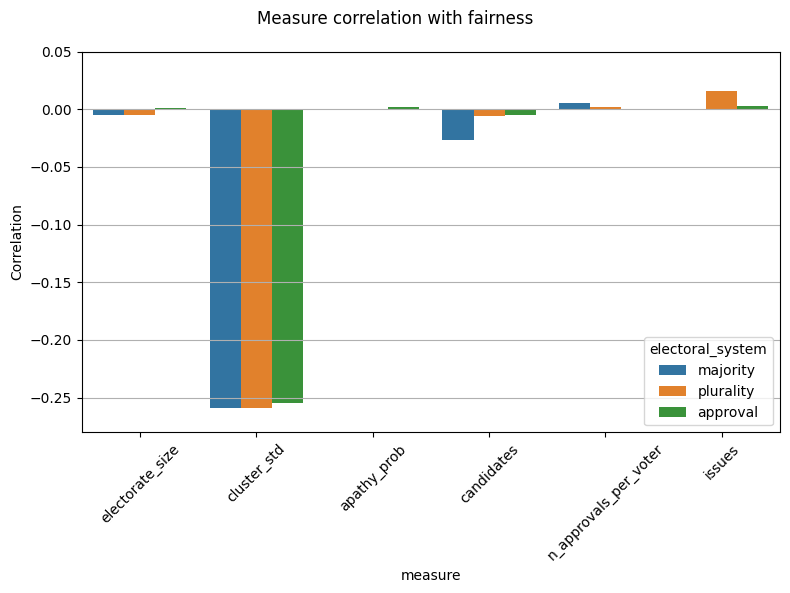

In [63]:
# drop the odd rows with non numerical value and plot
cleaned_clong_corr = long_corr_df[~long_corr_df.value.isin(["plurality", "majority", "approval"])]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), tight_layout=True)
sns.barplot(data=cleaned_clong_corr, x="measure", y="value", hue="electoral_system", ax=ax1)
ax1.set_ylim([-0.28, 0.05])
ax1.grid(axis="y")
ax1.set_ylabel("Correlation")
fig.suptitle("Measure correlation with fairness")
plt.xticks(rotation=45)
plt.show()

# Factor breakdown by OLS

Let's see what factors are actually influencing fairness (if any). We'll reuse the prior wide representation and [OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html). We setup a seperate model for each one as some factors are not applicable across the board (n_approvals for example).

In [45]:
import statsmodels.api as sm

##### Case for plurality

In [56]:
target = "weighted_fairness"
superflous_cols = ["weighted_fairness", "unweighted_fairness", "electoral_system", "n_approvals_per_voter"]
features = [c for c in results_df.columns if c not in superflous_cols]
results_subset_df = results_df[plurality]

# setup and get results
ols = sm.OLS(endog=results_subset_df[target], exog=results_subset_df[features]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      weighted_fairness   R-squared (uncentered):                   0.590
Model:                            OLS   Adj. R-squared (uncentered):              0.590
Method:                 Least Squares   F-statistic:                              1398.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        12:10:58   Log-Likelihood:                         -9631.8
No. Observations:                5832   AIC:                                  1.928e+04
Df Residuals:                    5826   BIC:                                  1.932e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
electorate_size  4.027e-05   1.91e-06     21.087      0.000    3.65e-05     4.4e-05
clusters           -0.0459      0.002    -27.309      0.000      -0.049      -0.043
cluster_std        -0.0163      0.017     -0.945      0.345      -0.050       0.018
apathy_prob         5.3999      0.750      7.199      0.000       3.929       6.870
candidates          0.1026      0.006     18.468      0.000       0.092       0.113
issues              0.0334      0.002     17.355      0.000       0.030       0.037
==============================================================================
Omnibus:                     1948.620   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6070.790
Skew:                           1.731   Prob(JB):                         0.00
Kurtosis:                       6.606   Cond. No.                     8.64e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Case for majority

In [53]:
target = "weighted_fairness"
superflous_cols = ["weighted_fairness", "unweighted_fairness", "electoral_system", "n_approvals_per_voter"]
features = [c for c in results_df.columns if c not in superflous_cols]
results_subset_df = results_df[majority]

# setup and get results
ols = sm.OLS(endog=results_subset_df[target], exog=results_subset_df[features]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      weighted_fairness   R-squared (uncentered):                   0.589
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              1393.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        12:00:20   Log-Likelihood:                         -9678.5
No. Observations:                5832   AIC:                                  1.937e+04
Df Residuals:                    5826   BIC:                                  1.941e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
electorate_size  4.035e-05   1.93e-06     20.957      0.000    3.66e-05    4.41e-05
clusters           -0.0470      0.002    -27.687      0.000      -0.050      -0.044
cluster_std        -0.0182      0.017     -1.048      0.295      -0.052       0.016
apathy_prob         5.6438      0.756      7.464      0.000       4.161       7.126
candidates          0.1067      0.006     19.050      0.000       0.096       0.118
issues              0.0324      0.002     16.742      0.000       0.029       0.036
==============================================================================
Omnibus:                     1963.928   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6234.609
Skew:                           1.736   Prob(JB):                         0.00
Kurtosis:                       6.688   Cond. No.                     8.64e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Case for ranked choice

In [55]:
target = "weighted_fairness"
superflous_cols = ["weighted_fairness", "unweighted_fairness", "electoral_system"]
features = [c for c in results_df.columns if c not in superflous_cols]
results_subset_df = results_df[approval]

# setup and get results
ols = sm.OLS(endog=results_subset_df[target], exog=results_subset_df[features]).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      weighted_fairness   R-squared (uncentered):                   0.610
Model:                            OLS   Adj. R-squared (uncentered):              0.609
Method:                 Least Squares   F-statistic:                              1108.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        12:02:14   Log-Likelihood:                         -8048.3
No. Observations:                4968   AIC:                                  1.611e+04
Df Residuals:                    4961   BIC:                                  1.616e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
electorate_size        3.153e-05   2.08e-06     15.164      0.000    2.74e-05    3.56e-05
clusters                 -0.0485      0.002    -27.327      0.000      -0.052      -0.045
cluster_std              -0.1004      0.019     -5.322      0.000      -0.137      -0.063
apathy_prob               4.4106      0.791      5.574      0.000       2.859       5.962
candidates                0.0808      0.007     11.647      0.000       0.067       0.094
issues                    0.0281      0.002     13.760      0.000       0.024       0.032
n_approvals_per_voter     0.1700      0.014     12.167      0.000       0.143       0.197
==============================================================================
Omnibus:                     1652.187   Durbin-Watson:                   0.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5108.784
Skew:                           1.723   Prob(JB):                         0.00
Kurtosis:                       6.578   Cond. No.                     8.68e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""